# Analysis of Generated Sequences
## Peneeta Wojcik

Code that compares RhoDesign-generated sequences to the original reference sequence using the Levenshtein distance (edit distance)

In [1]:
# !pip install levenshtein

In [2]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance as levenshtein_distance

In [4]:
def read_fasta(filepath):
    """Read sequences from a FASTA file."""
    sequences = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

def calculate_similarity(seq1, seq2):
    """
    Calculate sequence similarity as 1 - (normalized edit distance).
    Returns a value between 0 (completely different) and 1 (identical).
    """
    max_len = max(len(seq1), len(seq2))
    if max_len == 0:
        return 1.0
    edit_dist = levenshtein_distance(seq1, seq2)
    similarity = 1 - (edit_dist / max_len)
    return similarity

## Temp = 1

In [6]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T"]
base_dir = "./generated_seqs/"
fasta_dir = "./aptamers/fasta/"

In [7]:
results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")



Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T
Sequence                              
1         0.560976  0.704225  0.666667
2         0.512195  0.746479  0.722222
3         0.634146  0.802817  0.694444
4         0.414634  0.718310  0.638889
5         0.512195  0.704225  0.583333
6         0.487805  0.718310  0.555556
7         0.439024  0.732394  0.583333
8         0.634146  0.690141  0.611111
9         0.634146  0.704225  0.583333
10        0.487805  0.718310  0.555556
11        0.512195  0.746479  0.638889
12        0.439024  0.661972  0.583333
13        0.512195  0.718310  0.638889
14        0.536585  0.746479  0.555556
15        0.512195  0.760563  0.555556
16        0.487805  0.760563  0.472222
17        0.536585  0.760563  0.611111
18        0.463415  0.690141  0.611111
19        0.390244  0.661972  0.611111
20        0.536585  0.676056  0.666667


Statistics by Aptamer:
             mean       std
Aptamer                    
2AU4     0.512195  0.068072
5KPY     0.721

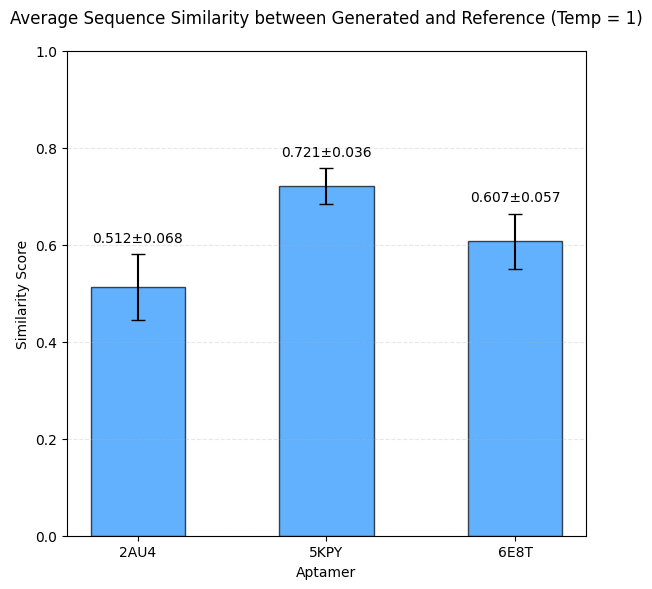

Plot saved as 'similarity_analysis.png'


In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='dodgerblue', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=10)
ax.set_ylabel('Similarity Score', fontsize=10)
ax.set_title('Average Sequence Similarity between Generated and Reference (Temp = 1)', 
             fontsize=12, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis.png'")

In [9]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons

Self-Similarity Statistics:
             mean       std  count
Aptamer                           
2AU4     0.598973  0.069822    190
5KPY     0.724685  0.052869    190
6E8T     0.592932  0.074394    190




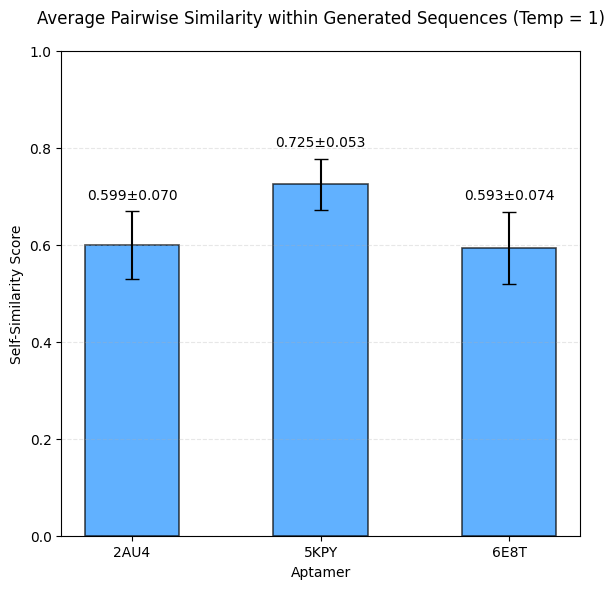

Self-similarity plot saved as 'self_similarity_analysis.png'


In [10]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='dodgerblue', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=10)
ax2.set_ylabel('Self-Similarity Score', fontsize=10)
ax2.set_title('Average Pairwise Similarity within Generated Sequences (Temp = 1)', 
              fontsize=12, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis.png'")

## Temp = 1e-5

In [11]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T"]
base_dir = "./generated_seqs_lowtemp/"
fasta_dir = "./aptamers/fasta/"

results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")

Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T
Sequence                              
1         0.463415  0.760563  0.694444
2         0.463415  0.760563  0.694444
3         0.463415  0.760563  0.694444
4         0.463415  0.760563  0.694444
5         0.463415  0.760563  0.694444
6         0.463415  0.760563  0.694444
7         0.463415  0.760563  0.694444
8         0.463415  0.760563  0.694444
9         0.463415  0.760563  0.694444
10        0.463415  0.760563  0.694444
11        0.463415  0.760563  0.694444
12        0.463415  0.760563  0.694444
13        0.463415  0.760563  0.694444
14        0.463415  0.760563  0.694444
15        0.463415  0.760563  0.694444
16        0.463415  0.760563  0.694444
17        0.463415  0.760563  0.694444
18        0.463415  0.760563  0.694444
19        0.463415  0.760563  0.694444
20        0.463415  0.760563  0.694444


Statistics by Aptamer:
             mean  std
Aptamer               
2AU4     0.463415  0.0
5KPY     0.760563  0.0
6E8T  

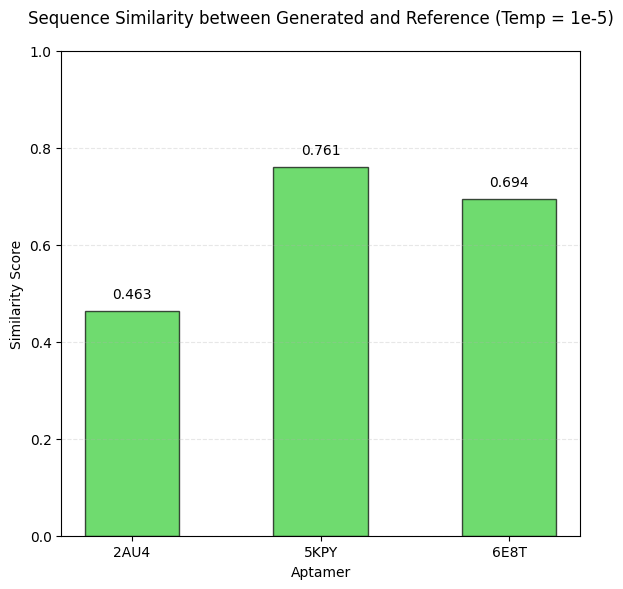

Plot saved as 'similarity_analysis_lowtemp.png'


In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means,  alpha=0.7, 
              color='limegreen', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=10)
ax.set_ylabel('Similarity Score', fontsize=10,)
ax.set_title('Sequence Similarity between Generated and Reference (Temp = 1e-5)', 
             fontsize=12, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis_lowtemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis_lowtemp.png'")

In [13]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons

Self-Similarity Statistics:
         mean  std  count
Aptamer                  
2AU4      1.0  0.0    190
5KPY      1.0  0.0    190
6E8T      1.0  0.0    190




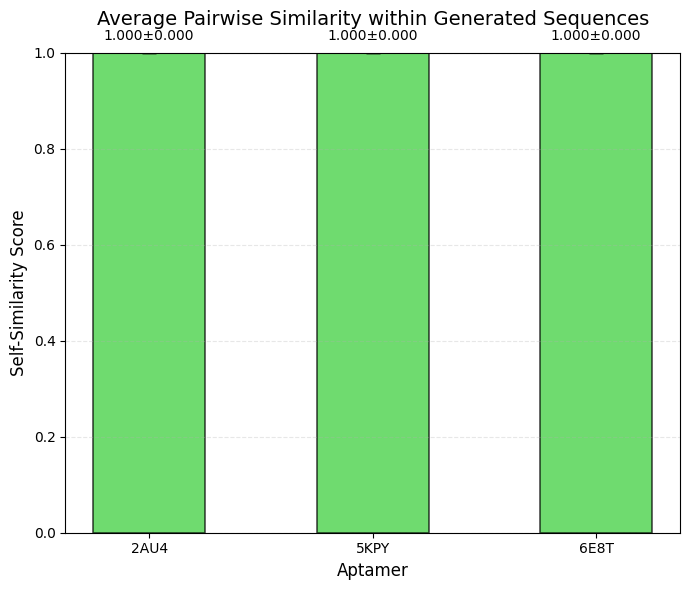

Self-similarity plot saved as 'self_similarity_analysis_lowtemp.png'


In [14]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='limegreen', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=12)
ax2.set_ylabel('Self-Similarity Score', fontsize=12)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=14, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis_lowtemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis_lowtemp.png'")